In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import torch
nbn = "02_" # Notebook Number; Prefix for artifacts path

In [40]:
datasets = ["Caltech256","SUN397","iWildCam","iWildCamOOD","CIFAR10","CINIC10"]
test_dypes = ["InD","InD","InD","OOD","InD","OOD"]
nrow, ncol=2,3
margin = 0.02
pred_prefix = "csv/prediction_"
unc_prefix = "csv/uncertainty_"
input_prefix = "../Pred/cal_"
target_prefix = "../Pred/"

In [41]:
def eval_pred(pred):
    results = []
    for col in pred.columns.drop("target"):
        acc = (pred[col] == pred["target"]).mean()
        results.append({"Method": col, "Accuracy": acc})
    return pd.DataFrame(results)
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    return np.argmax(sum_pred,axis=1)
def soft_vote_softmax(pred1, pred2):
    pred1_sm = F.softmax(torch.tensor(pred1.values),dim=1).numpy()
    pred2_sm = F.softmax(torch.tensor(pred2.values),dim=1).numpy()
    sum_pred = pred1_sm+pred2_sm
    return np.argmax(sum_pred,axis=1)
def cons_weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    return np.argmax(weighted_pred,axis=1)
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    return np.argmax(weighted_pred,axis=1)

def barplot_acc(pred, ds, ax):
    results_df = eval_pred(pred)
    
    sns.barplot(x='Method', y='Accuracy', data=results_df, ax=ax)
    
    # pred101_acc = results_df.loc[results_df['Method'] == 'pred101', 'Accuracy'].values[0]
    pred50_acc = results_df.loc[results_df['Method'] == 'pred50', 'Accuracy'].values[0]
    pred18_acc = results_df.loc[results_df['Method'] == 'pred18', 'Accuracy'].values[0]
    
    baseline_acc = max(pred50_acc, pred18_acc)
    baseline_method = 'pred50' if baseline_acc == pred50_acc else 'pred18'
    
    ax.axhline(y=baseline_acc, color='r', linestyle='--')
    ax.text(len(results_df) - 1, baseline_acc, f"Baseline ({baseline_method}): {baseline_acc:.2%}", color='r', ha='center', va='bottom')
    
    for index, row in results_df.iterrows():
        ax.text(index, row['Accuracy'], f"{row['Accuracy']:.2%}", color='black', ha="center")
    
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(f'Ensemble Accuracy on {ds}')
    ax.set_xlabel('Ensembling Method')
    ax.set_ylabel('Accuracy')
    
    min_acc = results_df['Accuracy'].min()
    max_acc = results_df['Accuracy'].max()
    ax.set_ylim(min_acc - margin, min(1, max_acc + margin))

In [42]:
# fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

# for i, ds in enumerate(datasets):
#     df18 = pd.read_csv(f"../Pred/{ds}_Resnet18.csv")
#     df50 = pd.read_csv(f"../Pred/{ds}_Resnet50.csv")
#     df101 = pd.read_csv(f"../Pred/{ds}_Resnet101.csv")
#     label = pd.read_csv(f"../Pred/target_{ds}.csv")
#     pred = pd.read_csv(f"{pred_prefix}{ds}.csv", index_col="Unnamed: 0")
#     unc_pred = pd.read_csv(f"{unc_prefix}{ds}.csv", index_col="Unnamed: 0")
#     pred["soft_vote(avg-softmax)"] = soft_vote(df18, df101)
#     pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_101"],pred["pred101"],pred["pred18"])
#     pred["ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])
#     pred["kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
#     pred["ce_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ce_101_18"], unc_pred["ce_18_101"])
#     pred["ent_pow_kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"]**unc_pred["kl_101_18"], unc_pred["ent_18"]**unc_pred["kl_18_101"])
#     pred["kl_sqr_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**2, unc_pred["kl_18_101"]**2)
#     pred["kl_times_ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]*unc_pred["ent_101"], unc_pred["kl_18_101"]*unc_pred["ent_18"])
#     ax = axes[i // ncol, i % ncol]
#     barplot_acc(pred,ds,ax)
# plt.subplots_adjust(hspace=1)
# plt.suptitle("Ensemble Methods Accuracy across Datasets")
# plt.savefig(f"artifacts/{nbn}ensemble.png")
# plt.show()

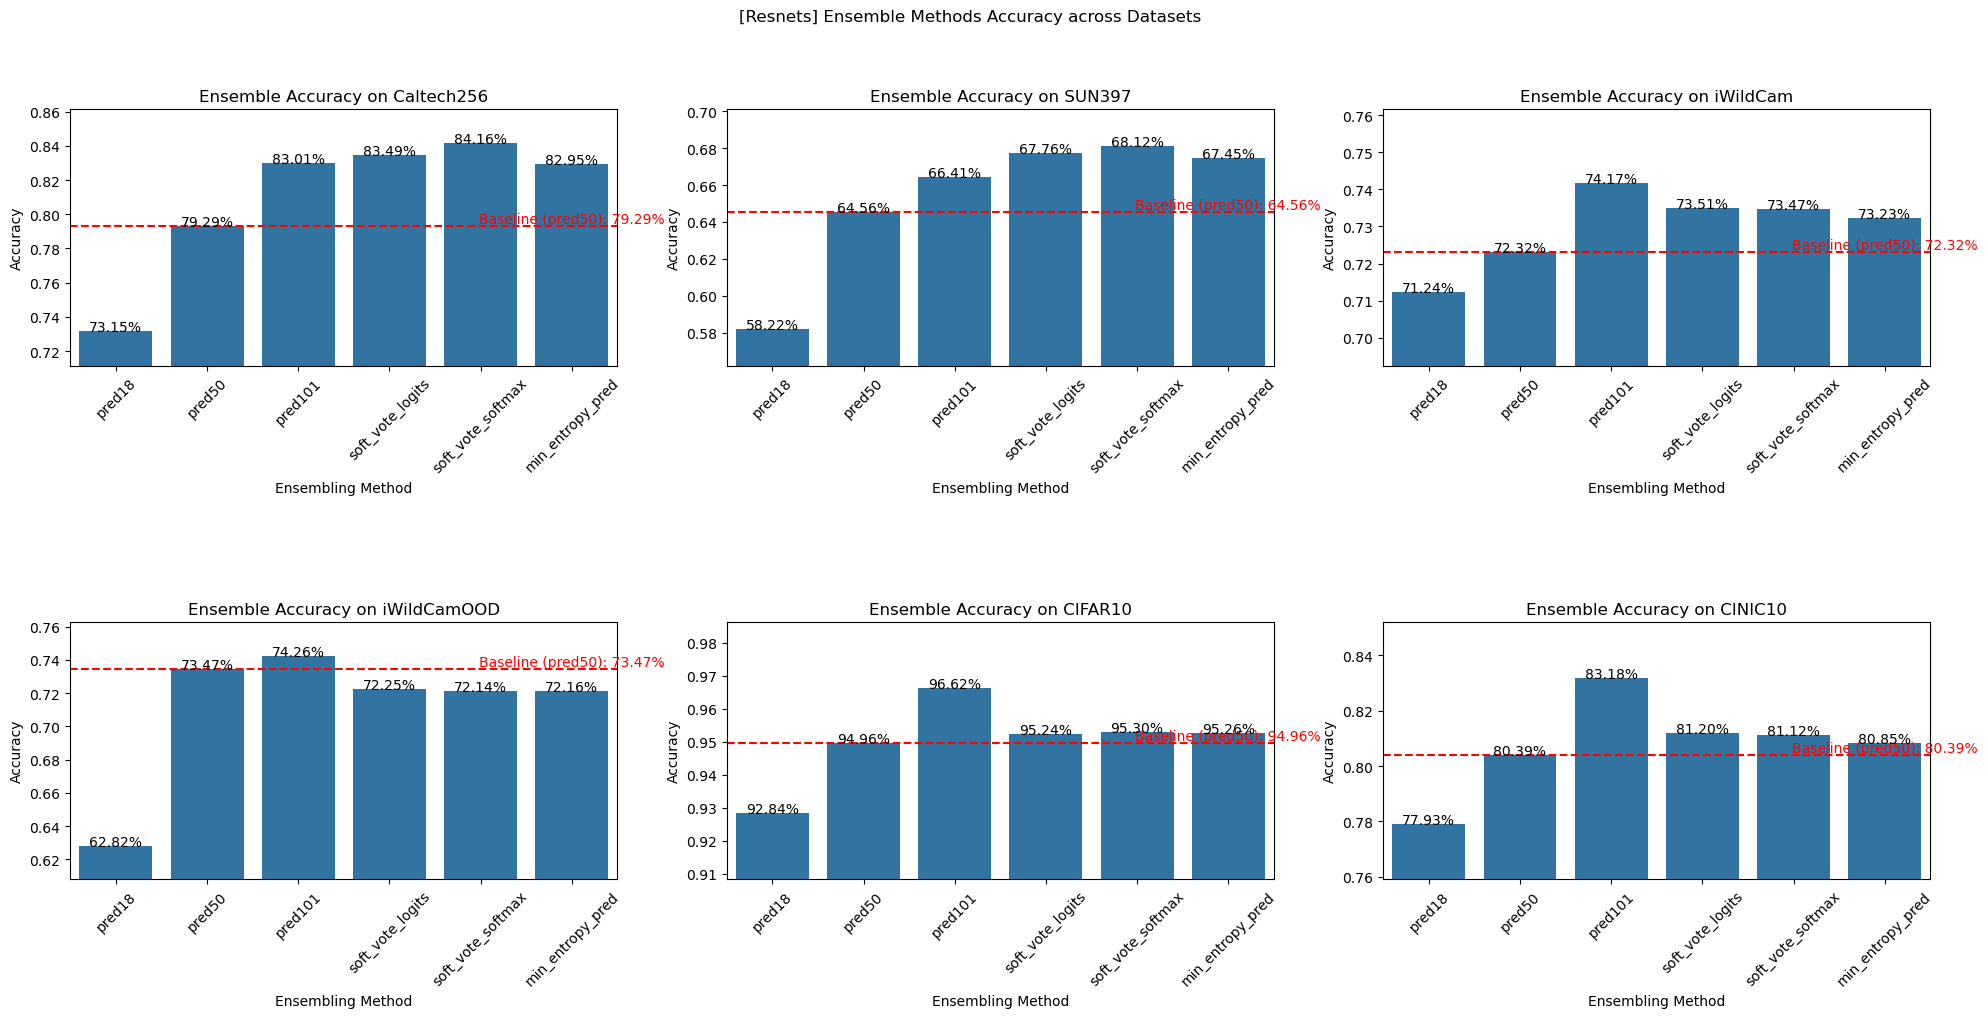

In [43]:
fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

for i, ds in enumerate(datasets):
    df18 = pd.read_csv(f"{input_prefix}{ds}_Resnet18.csv")
    df50 = pd.read_csv(f"{input_prefix}{ds}_Resnet50.csv")
    df101 = pd.read_csv(f"{input_prefix}{ds}_Resnet101.csv")
    label = pd.read_csv(f"{target_prefix}target_{ds}.csv")
    pred = pd.read_csv(f"{pred_prefix}{ds}_Resnet.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_prefix}{ds}_Resnet.csv", index_col="Unnamed: 0")
    pred["soft_vote_logits"] = soft_vote(df18, df50)
    pred["soft_vote_softmax"] = soft_vote_softmax(df18, df50)
    pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_50"],pred["pred50"],pred["pred18"])
    pred.to_csv(f"{pred_prefix}{ds}_Resnet.csv")
    ax = axes[i // ncol, i % ncol]
    barplot_acc(pred,ds,ax)
plt.subplots_adjust(hspace=1)
plt.suptitle("[Resnets] Ensemble Methods Accuracy across Datasets")
plt.savefig(f"artifacts/{nbn}ensemble(18n50)_resnet.png")
plt.show()

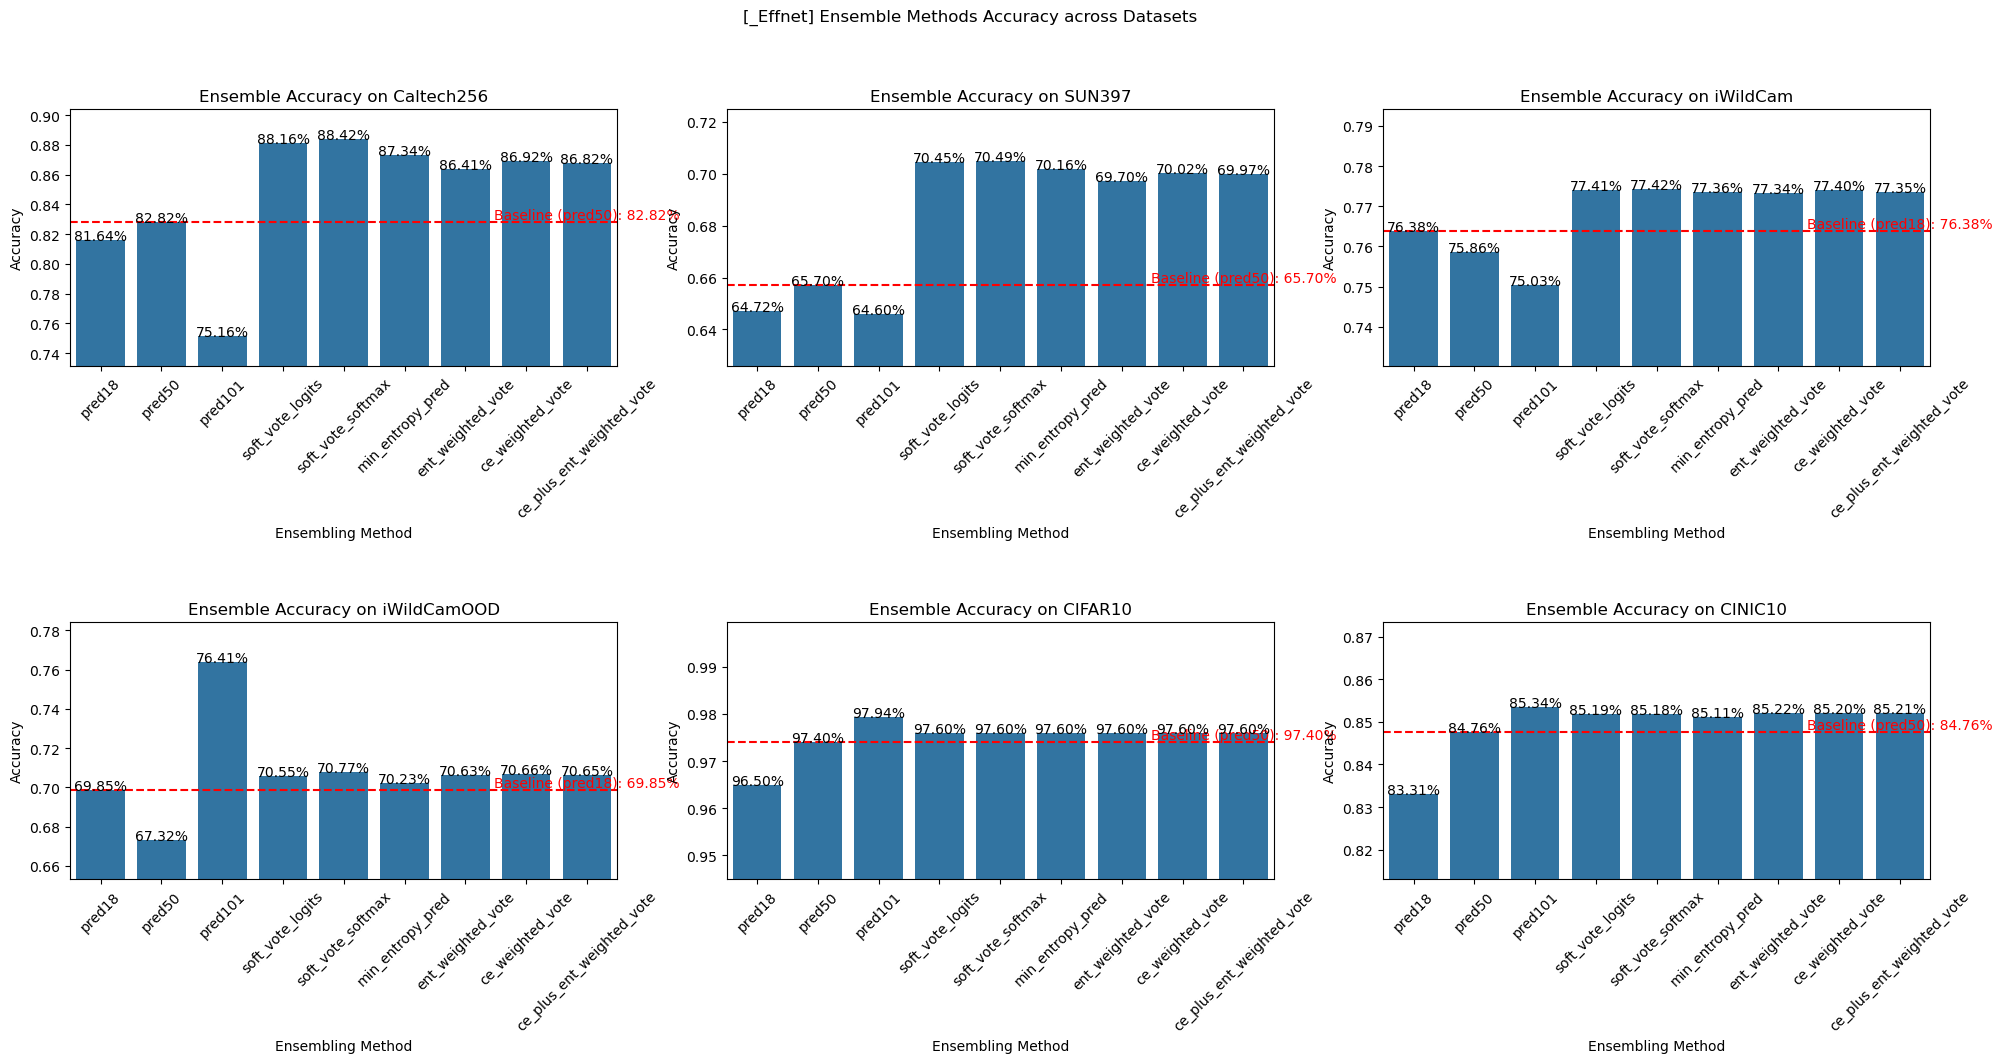

In [44]:
fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))
suffix = "_Effnet"
for i, ds in enumerate(datasets):
    df18 = pd.read_csv(f"{input_prefix}{ds}_EffNet_S.csv")
    df50 = pd.read_csv(f"{input_prefix}{ds}_EffNet_M.csv")
    df101 = pd.read_csv(f"{input_prefix}{ds}_EffNet_L.csv")
    label = pd.read_csv(f"{target_prefix}target_{ds}.csv")
    pred = pd.read_csv(f"{pred_prefix}{ds}{suffix}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_prefix}{ds}{suffix}.csv", index_col="Unnamed: 0")
    pred["soft_vote_logits"] = soft_vote(df18, df50)
    pred["soft_vote_softmax"] = soft_vote_softmax(df18, df50)
    pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_50"],pred["pred50"],pred["pred18"])
    pred["ent_weighted_vote"] = vec_weighted_vote(df18, df50, unc_pred["ent_50"], unc_pred["ent_18"])
    # pred["kl_weighted_vote"] = vec_weighted_vote(df18, df50, unc_pred["kl_50_18"], unc_pred["kl_18_50"])
    pred["ce_weighted_vote"] = vec_weighted_vote(df18, df50, unc_pred["ce_50_18"], unc_pred["ce_18_50"])
    # pred["ent_pow_kl_weighted_vote"] = vec_weighted_vote(df18, df50, unc_pred["ent_50"]**unc_pred["kl_50_18"], unc_pred["ent_18"]**unc_pred["kl_18_50"])
    # pred["kl_sqr_weighted_vote"] = vec_weighted_vote(df18, df50, unc_pred["kl_50_18"]**2, unc_pred["kl_18_50"]**2)
    pred["ce_plus_ent_weighted_vote"] = vec_weighted_vote(df18, df50, unc_pred["ce_50_18"]+unc_pred["ent_50"], unc_pred["ce_18_50"]+unc_pred["ent_18"])
    pred.to_csv(f"{pred_prefix}{ds}{suffix}.csv")
    ax = axes[i // ncol, i % ncol]
    barplot_acc(pred,ds,ax)
plt.subplots_adjust(hspace=1)
plt.suptitle(f"[{suffix}] Ensemble Methods Accuracy across Datasets")
plt.savefig(f"artifacts/{nbn}ensemble(18n50){suffix}.png")
plt.show()

In [45]:
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    row_sums = sum_pred.sum(axis=1)
    normalized_pred = sum_pred.div(row_sums, axis=0)
    return normalized_pred
def cons_weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    row_sums = weighted_pred.sum(axis=1)
    normalized_pred = weighted_pred.div(row_sums, axis=0)
    return normalized_pred
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    row_sums = weighted_pred.sum(axis=1)
    normalized_pred = weighted_pred.div(row_sums, axis=0)
    return normalized_pred

In [46]:
lap_eps = 1e-5
def laplace_pred_mat(P):
    P+=lap_eps
    row_sums = P.sum(axis=1)
    normalized_P = P.div(row_sums, axis=0)
    return normalized_P

def eval_pred_nll(pred_ls,ens_name_ls,label):
    results = []
    flat_label = label['target'].values.flatten()
    for i, curr_pred in enumerate(pred_ls):
        curr_pred = laplace_pred_mat(curr_pred)
        curr_array = curr_pred.values
        nll = np.mean(-np.log(curr_array[np.arange(curr_pred.shape[0]), flat_label]))
        results.append({"Method": ens_name_ls[i], "NLL": nll})
    return pd.DataFrame(results)

def barplot_nll(pred_ls,ens_name_ls, label, ds,ax):
    results_df = eval_pred_nll(pred_ls,ens_name_ls,label)
    
    # display(results_df)
    
    sns.barplot(x='Method', y='NLL', data=results_df, ax=ax)
    pred101_nll = results_df.loc[results_df['Method'] == 'Resnet101', 'NLL'].values[0]
    pred18_nll = results_df.loc[results_df['Method'] == 'Resnet18', 'NLL'].values[0]
    
    baseline_nll = min(pred101_nll, pred18_nll)
    baseline_method = 'Resnet101' if baseline_nll == pred101_nll else 'Resnet18'
    
    ax.axhline(y=baseline_nll, color='r', linestyle='--')
    ax.text(len(results_df) - 1, baseline_nll, f"Baseline ({baseline_method}): {baseline_nll:.2f}", color='r', ha='center', va='bottom')
    
    for index, row in results_df.iterrows():
        ax.text(index, row['NLL'], f"{row['NLL']:.2f}", color='black', ha="center")
    
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(f'Ensemble NLL on {ds} (lower is better)')
    ax.set_xlabel('Ensembling Method')
    ax.set_ylabel('NLL')

FileNotFoundError: [Errno 2] No such file or directory: 'csv/uncertainty_Caltech256.csv'

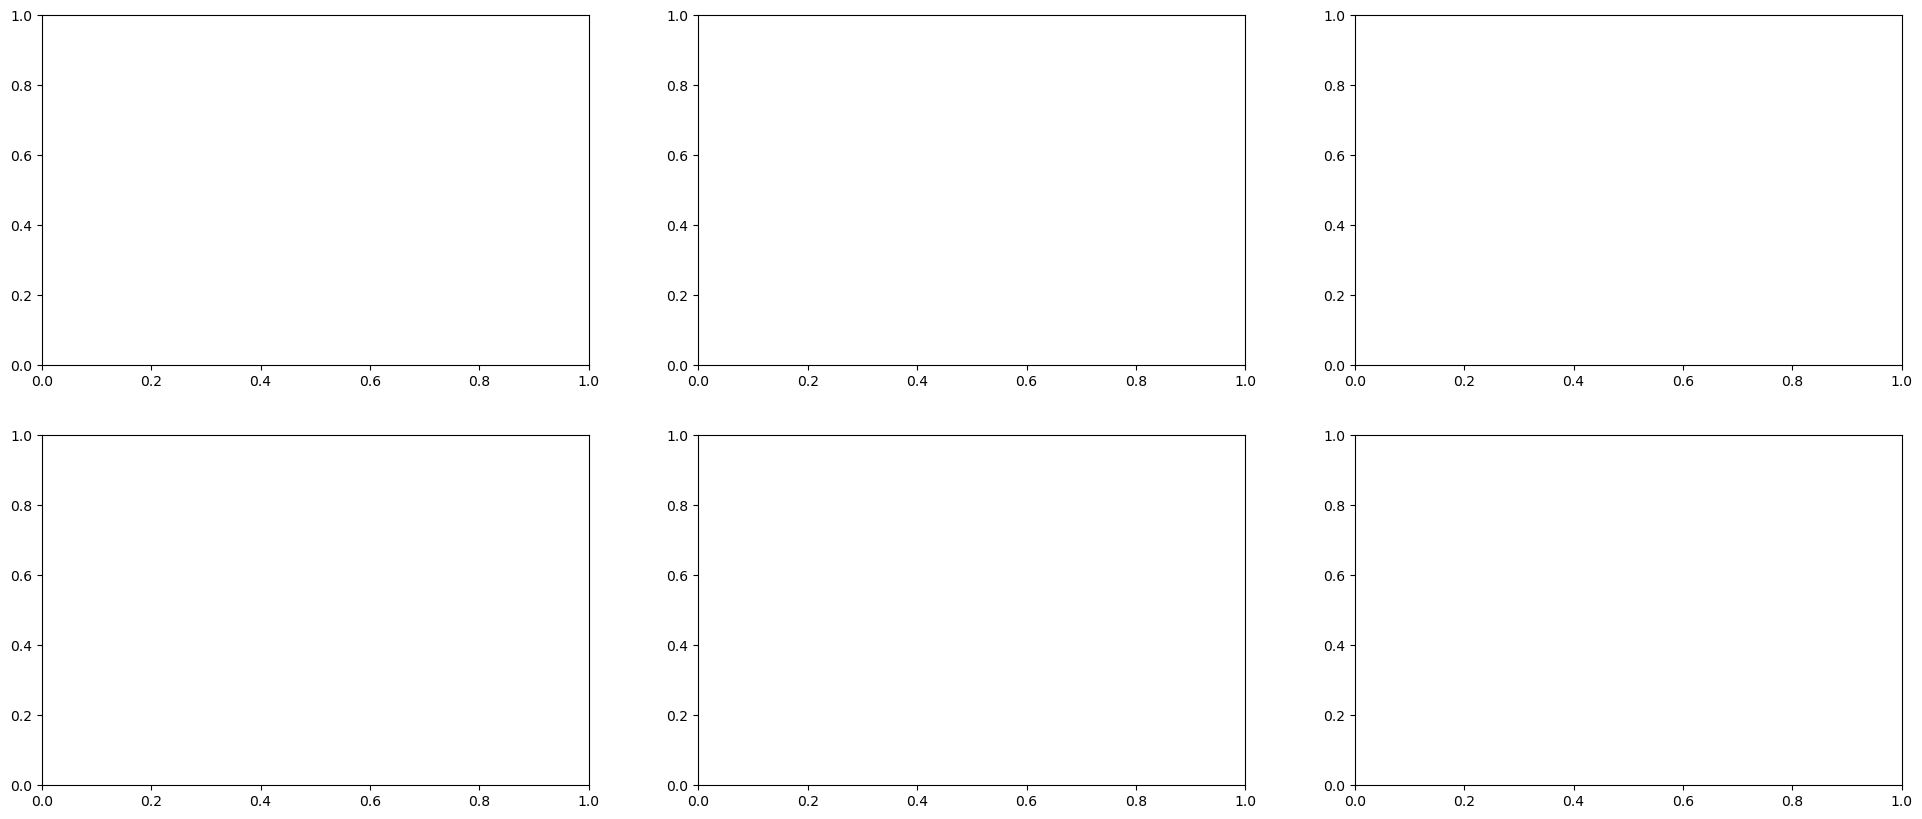

In [47]:
fig, axes = plt.subplots(nrow, ncol, figsize=(8*ncol, 5*nrow))

for i, ds in enumerate(datasets):
    df18 = pd.read_csv(f"../Pred/{ds}_Resnet18.csv")
    df101 = pd.read_csv(f"../Pred/{ds}_Resnet101.csv")
    label = pd.read_csv(f"../Pred/target_{ds}.csv")
    unc_pred = pd.read_csv(f"{unc_prefix}{ds}.csv", index_col="Unnamed: 0")
    df_soft_vote = soft_vote(df18, df101)
    df_entr_w = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])
    df_kl_w = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
    df_ce_w = vec_weighted_vote(df18, df101, unc_pred["ce_101_18"], unc_pred["ce_18_101"])
    df_entr_pow_kl_w = vec_weighted_vote(df18, df101, unc_pred["ent_101"]**unc_pred["kl_101_18"], unc_pred["ent_18"]**unc_pred["kl_18_101"])
    df_kl_sqr_w = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**2, unc_pred["kl_18_101"]**2)
    df_kl_t_entr_w = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]*unc_pred["ent_101"], unc_pred["kl_18_101"]*unc_pred["ent_18"])
    ax = axes[i // ncol, i % ncol]
    pred_ls = [df18,df101,df_soft_vote, df_entr_w, df_kl_w, df_ce_w, df_entr_pow_kl_w, df_kl_sqr_w, df_kl_t_entr_w]
    ens_name_ls = ["Resnet18","Resnet101","Average Vote", "Entropy Weighted", "KL Weighted", "Cross Entropy Weighted", "Entropy^KL Weighted", "KL^2 Weighted", "KL*Entropy Weighted"]
    barplot_nll(pred_ls,ens_name_ls,label,ds,ax)
plt.subplots_adjust(hspace=1)
plt.suptitle("Ensemble Methods NLL across Datasets")
plt.savefig(f"artifacts/{nbn}ensemble_nll.png")
plt.show()

It's surprising that simply averaging predictions from a smaller model and a larger model is consistantly improving on accuracy, investigate: what kind of data is ensemble more likely to get right?
For this part let's focus on soft_vote since that's the simplest one

In [ ]:
def soft_vote(pred1, pred2):
    sum_pred = pred1+pred2
    return np.argmax(sum_pred,axis=1)
def cons_weighted_vote(pred1, pred2, weight1, weight2):
    weighted_pred = np.multiply(weight1,pred1)+np.multiply(weight2,pred2)
    return np.argmax(weighted_pred,axis=1)
def vec_weighted_vote(pred1, pred2, weightvec1, weightvec2):
    weighted_pred = pred1.mul(weightvec1, axis=0) + pred2.mul(weightvec2, axis=0)
    return np.argmax(weighted_pred,axis=1)

In [ ]:
def load_data(ds):
    df18 = pd.read_csv(f"../Pred/{ds}_Resnet18.csv")
    df101 = pd.read_csv(f"../Pred/{ds}_Resnet101.csv")
    label = pd.read_csv(f"../Pred/target_{ds}.csv")
    pred = pd.read_csv(f"{pred_prefix}{ds}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_prefix}{ds}.csv", index_col="Unnamed: 0")
    pred["soft_vote(avg-softmax)"] = soft_vote(df18, df101)
    pred["min_entropy_pred"] = np.where(unc_pred["ent_18"]>unc_pred["ent_101"],pred["pred101"],pred["pred18"])
    pred["ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"], unc_pred["ent_18"])
    pred["kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"], unc_pred["kl_18_101"])
    pred["ce_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ce_101_18"], unc_pred["ce_18_101"])
    pred["ent_pow_kl_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["ent_101"]**unc_pred["kl_101_18"], unc_pred["ent_18"]**unc_pred["kl_18_101"])
    pred["kl_sqr_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]**2, unc_pred["kl_18_101"]**2)
    pred["kl_times_ent_weighted_vote"] = vec_weighted_vote(df18, df101, unc_pred["kl_101_18"]*unc_pred["ent_101"], unc_pred["kl_18_101"]*unc_pred["ent_18"])
    return df18, df101, label, pred, unc_pred

In [ ]:
def plot_kde(ax, data, title, label_suffix=''):
    sns.kdeplot(data=data, x="ent_18", label=f"entropy 18 {label_suffix}", ax=ax)
    sns.kdeplot(data=data, x="ent_101", label=f"entropy 101 {label_suffix}", ax=ax)
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('Entropy')
    ax.set_ylabel('Density')

In [ ]:
def plot_predictions(pred, unc_pred, axes_row, ens_method):
    conditions = [
        (pred["pred18"] == pred["target"]) & (pred["pred101"] == pred["target"]) & (pred[ens_method] == pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] == pred["target"]) & (pred[ens_method] == pred["target"]),
        (pred["pred18"] == pred["target"]) & (pred["pred101"] != pred["target"]) & (pred[ens_method] == pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] != pred["target"]) & (pred[ens_method] == pred["target"]),
        (pred["pred18"] == pred["target"]) & (pred["pred101"] == pred["target"]) & (pred[ens_method] != pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] == pred["target"]) & (pred[ens_method] != pred["target"]),
        (pred["pred18"] == pred["target"]) & (pred["pred101"] != pred["target"]) & (pred[ens_method] != pred["target"]),
        (pred["pred18"] != pred["target"]) & (pred["pred101"] != pred["target"]) & (pred[ens_method] != pred["target"])
    ]
    
    titles = [
        '18 Cor & 101 Cor: #{}',
        '18 Incor & 101 Cor: #{}',
        '18 Cor & 101 Incor: #{}',
        '18 Incor & 101 Incor: #{}'
    ]
    
    for i, ax in enumerate(axes_row[:4]):
        condition = conditions[i]
        filtered_unc_pred = unc_pred[condition]
        temp_title = titles[i].format(filtered_unc_pred.shape[0])
        plot_kde(ax, filtered_unc_pred, temp_title, label_suffix='; Correct Soft Vote')
        condition = conditions[i + 4]
        filtered_unc_pred = unc_pred[condition]
        plot_kde(ax, filtered_unc_pred, temp_title+"||"+str(filtered_unc_pred.shape[0]), label_suffix='; Incorrect Soft Vote')


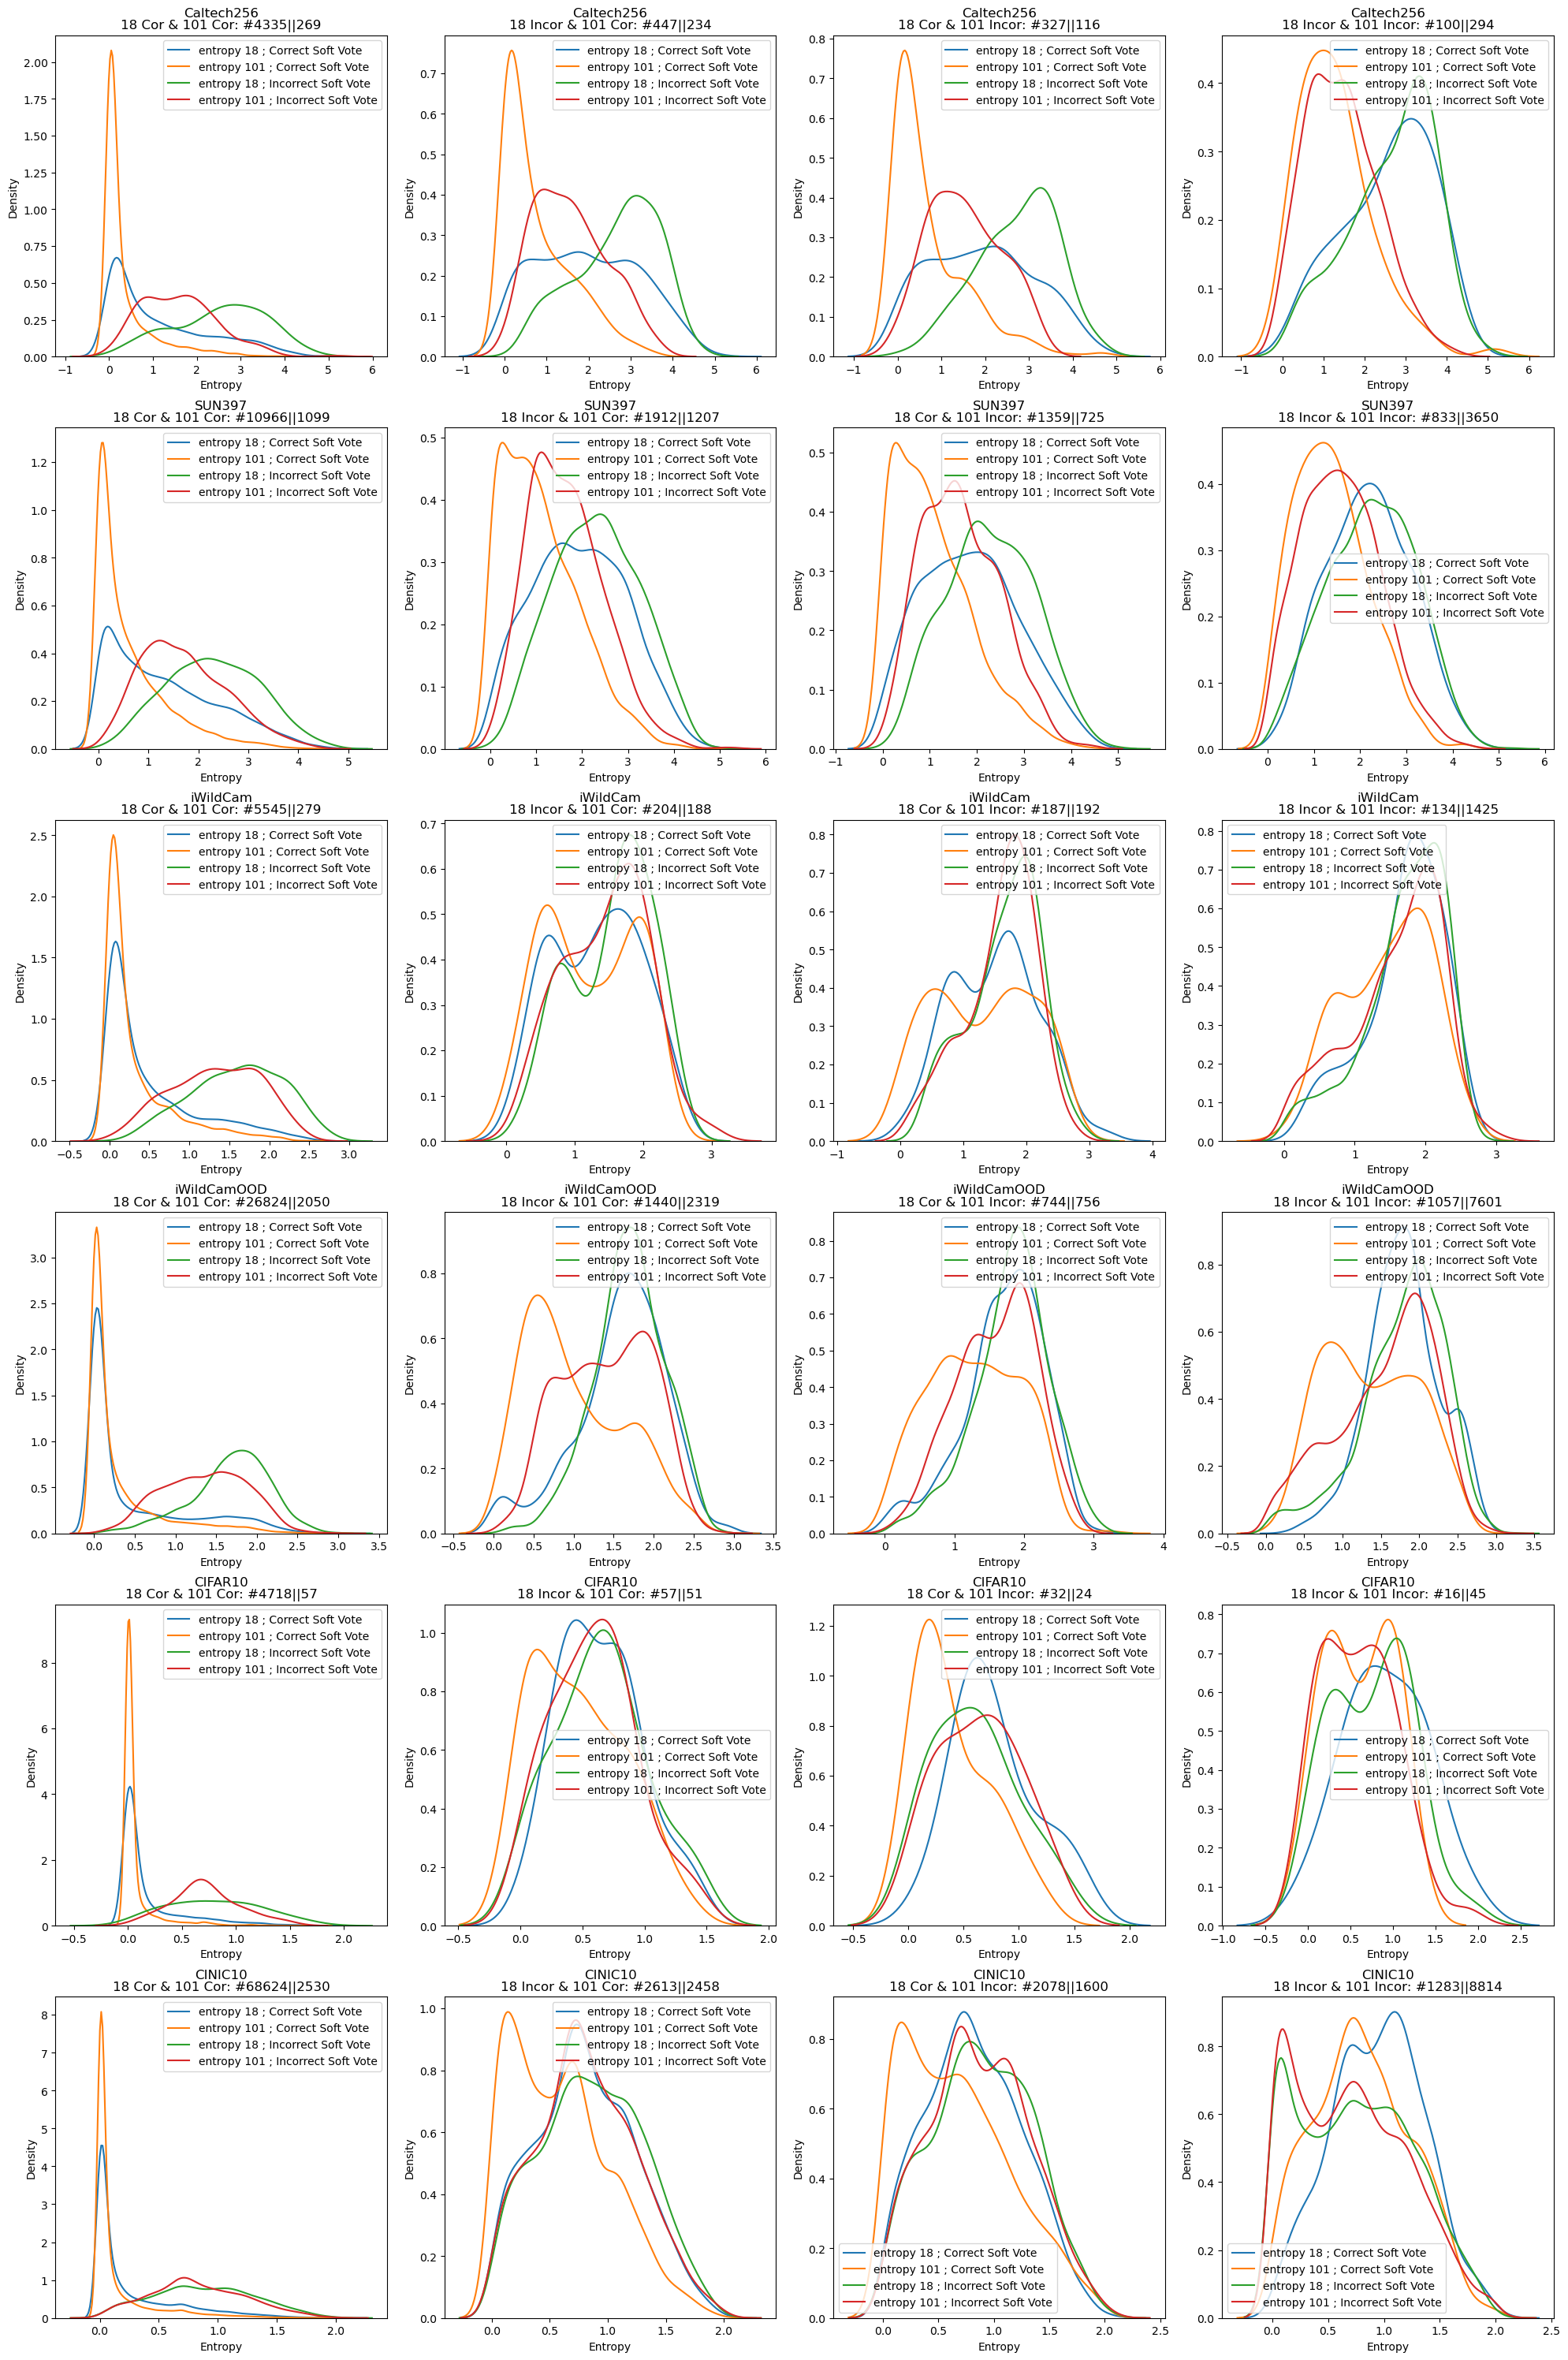

In [ ]:
fig, axes = plt.subplots(len(datasets), 4, figsize=(20, 5 * len(datasets)))

# If there's only one dataset, axes will not be a 2D array
if len(datasets) == 1:
    axes = [axes]

for i, ds in enumerate(datasets):
    df18, df101, label, pred, unc_pred = load_data(ds)
    plot_predictions(pred, unc_pred, axes[i], "soft_vote(avg-softmax)")
    for ax in axes[i]:
        ax.text(0.5, 1.05, ds, transform=ax.transAxes, ha='center', va='bottom', fontsize='large')

plt.tight_layout()
plt.savefig(f"artifacts/{nbn}entropy_conditioned_on_soft_vote.png")
# plt.show()

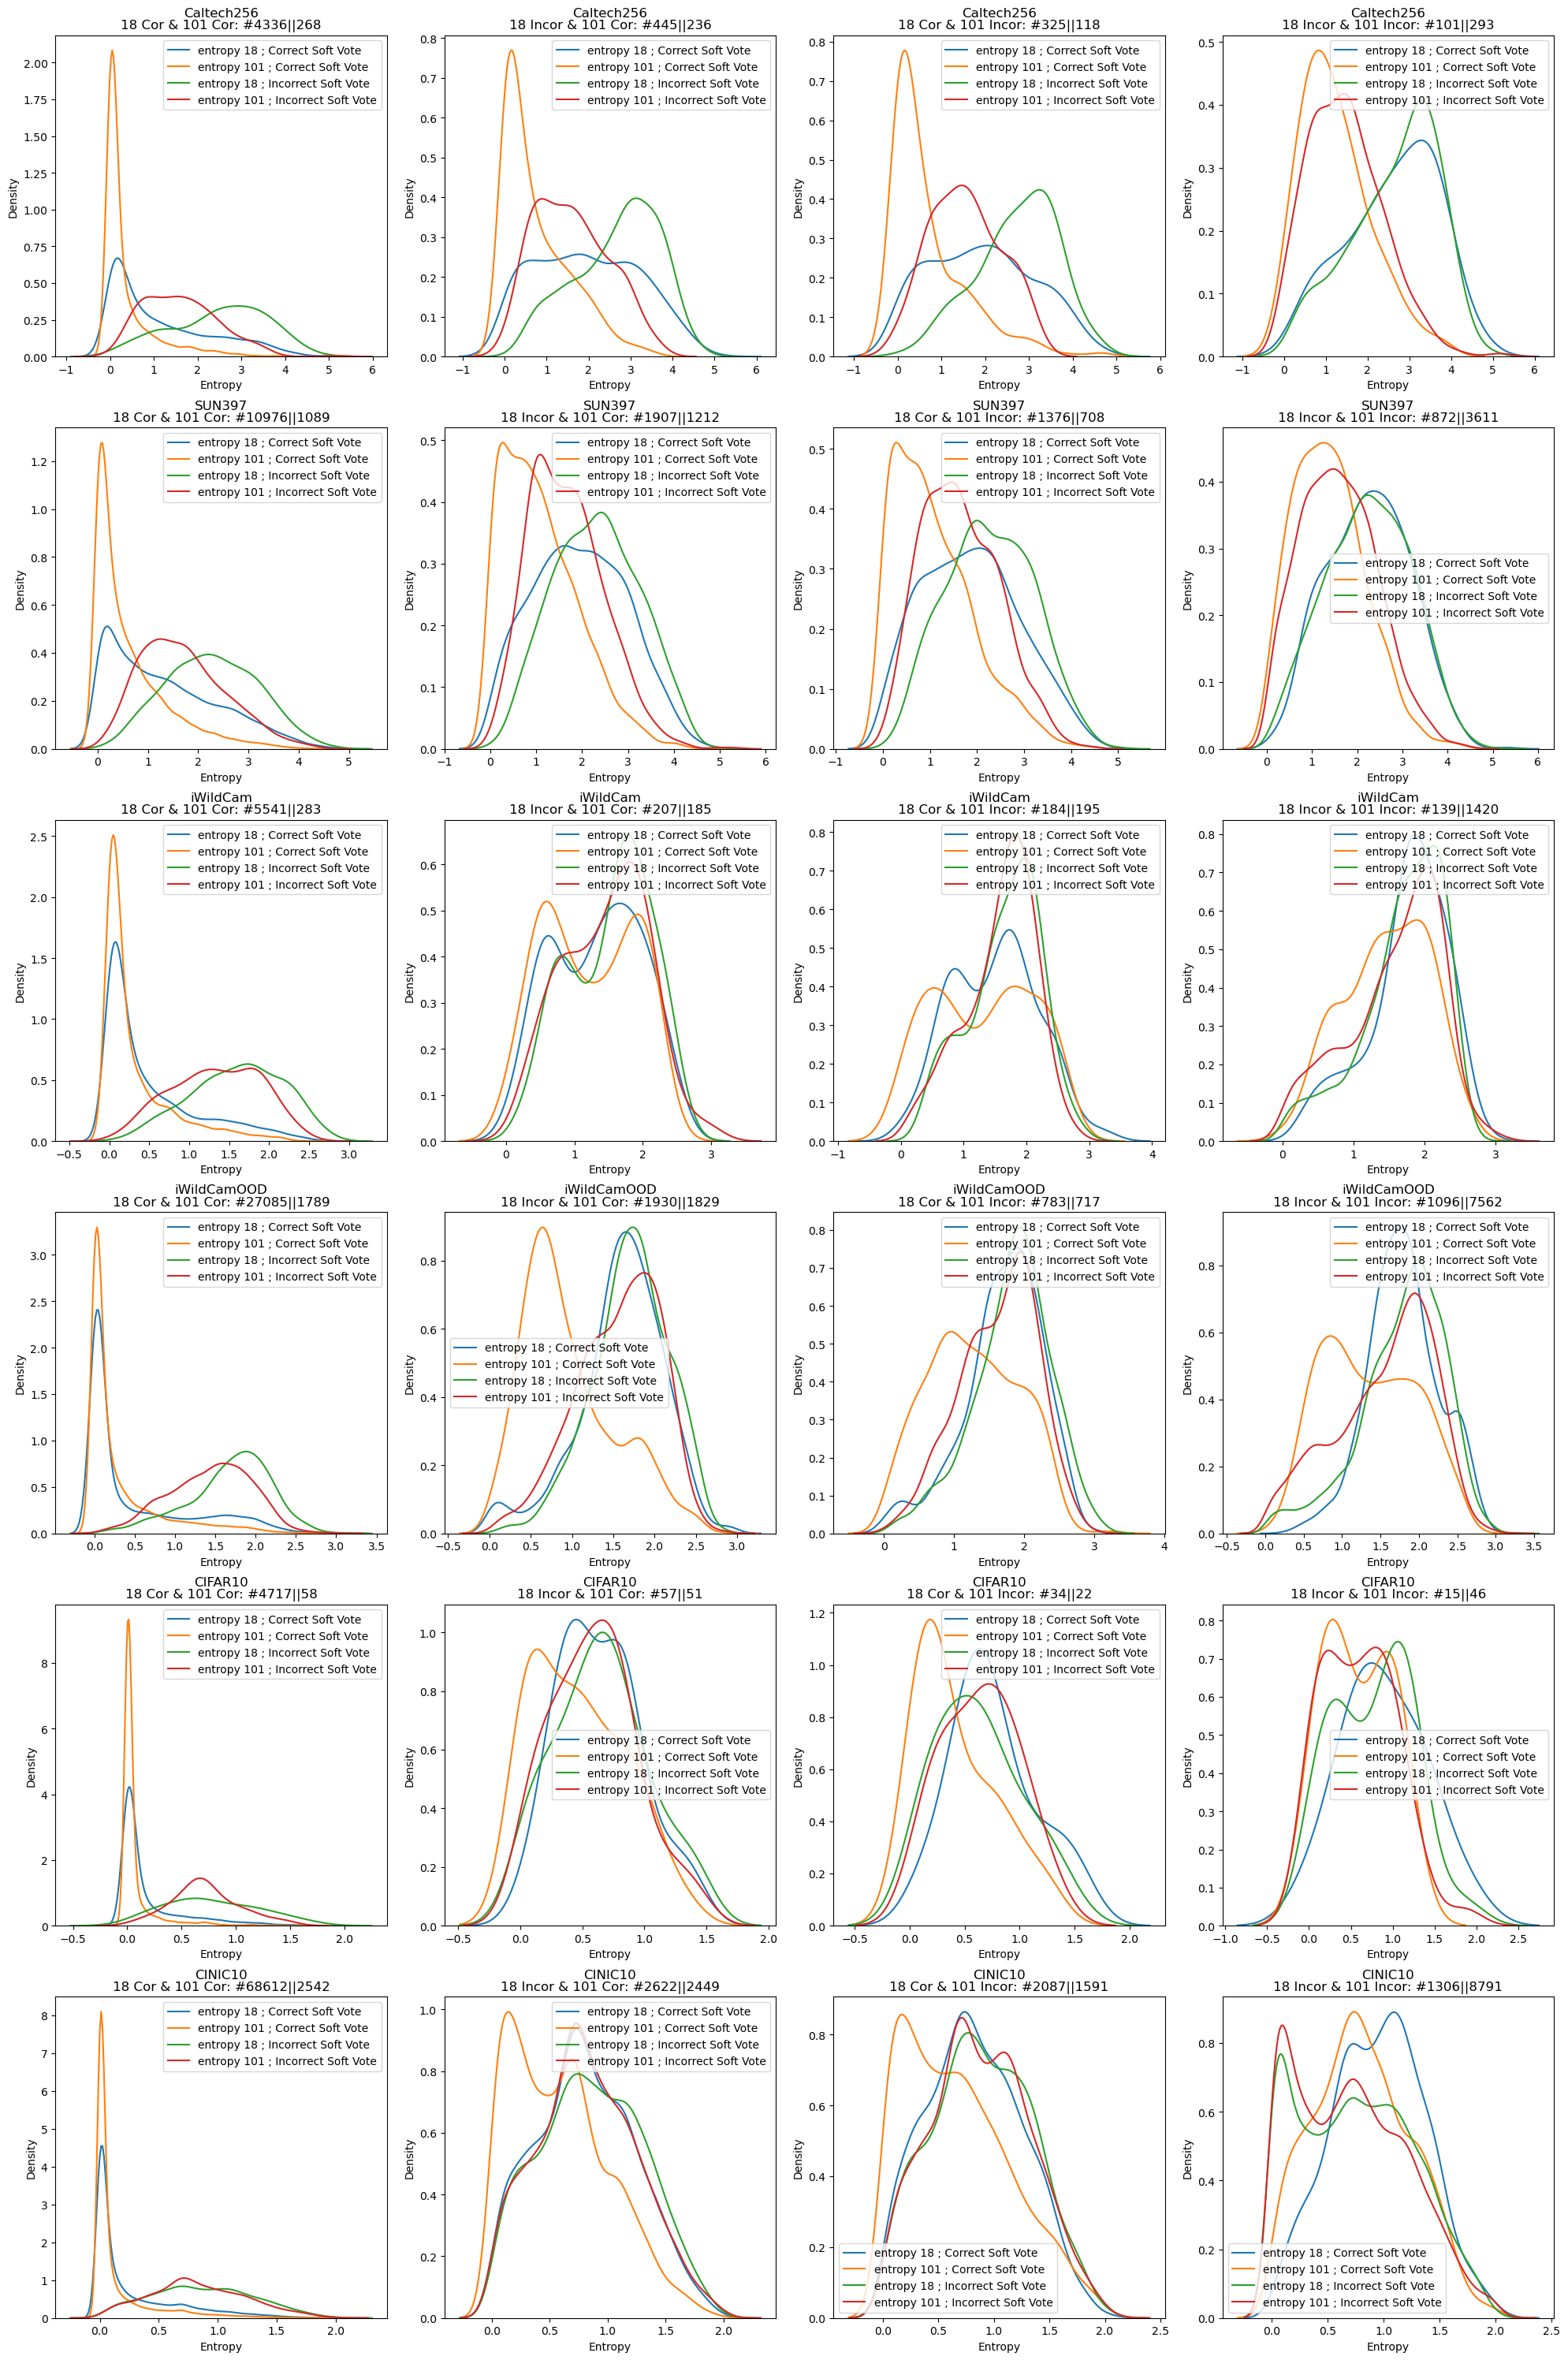

In [ ]:
fig, axes = plt.subplots(len(datasets), 4, figsize=(20, 5 * len(datasets)))

# If there's only one dataset, axes will not be a 2D array, so handle that case
if len(datasets) == 1:
    axes = [axes]

for i, ds in enumerate(datasets):
    df18, df101, label, pred, unc_pred = load_data(ds)
    plot_predictions(pred, unc_pred, axes[i], "ent_pow_kl_weighted_vote")
    for ax in axes[i]:
        ax.text(0.5, 1.05, ds, transform=ax.transAxes, ha='center', va='bottom', fontsize='large')

plt.tight_layout()
plt.savefig(f"artifacts/{nbn}entropy_conditioned_on_entr_pow_kl.png")
plt.show()